### Description :

Given file (as_tweets.txt) contains 100,000 tweets about the movie “American Sniper”. These are unprocessed real tweets. As you may know, the movie was directed by Clint Eastwood, starring Bradley Cooper and was based on the life story of Chris Kyle.

First task is to break the twitter hashtags into proper words, for example:
#goldenglobes -> golden globes,
#siennamiller -> sienna miller ... Example 1

Your second task is to find out what people have said about these three personalities (Clint Eastwood, Bradley Cooper and Chris Kyle), in other words find out the top trending topics about these people in the current dataset. A trend can be a single word (stunning) or may comprise of multiple words (looks stunning) as shown in Example2 below. Show 5 top trends per person. The tweet count should be in decreasing order.

### Solution:

Importing packages

In [39]:
# !pip install ujson 
# !pip install ekphrasis
# !pip install wordcloud
# !pip install tweet-preprocessor

from ekphrasis.classes.segmenter import Segmenter

seg_tw = Segmenter(corpus="twitter")

seg_eng = Segmenter(corpus="english")

import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
import string
import preprocessor as p
from nltk.corpus import stopwords
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

Reading tweets from text file

In [40]:
data = pd.read_csv("C:\\Users\\Suhas\\Downloads\\as_tweets\\as_tweets.txt",delimiter="\t")

In [119]:
data.shape

(99155, 5)

In [41]:
display(data.head())

,American Sniper
0,If American Sniper doesn't make you proud to b...
1,Retweet if you're going to see the movie Ameri...
2,Retweet if you're going to see the movie Ameri...
3,Retweet if you're going to see the movie Ameri...
4,Fav if you're going to see the movie American ...


In [42]:
data = data.rename(columns={'American Sniper': 'tweets'})

Analyzing the text data

In [43]:
# Count number of words in each row
data['word_count'] = data['tweets'].apply(lambda x: len(str(x).split(" ")))

# Count Number of characters in each row
# this also includes spaces
data['chr_count'] = data['tweets'].str.len() ## this also includes spaces

In [44]:
data.head(5)

,tweets,word_count,chr_count
0,If American Sniper doesn't make you proud to b...,20,130
1,Retweet if you're going to see the movie Ameri...,11,79
2,Retweet if you're going to see the movie Ameri...,11,79
3,Retweet if you're going to see the movie Ameri...,11,79
4,Fav if you're going to see the movie American ...,11,76


#### Task 1: To break the twitter hashtags into proper words

In [45]:
data['hashtags'] = data['tweets'].apply(lambda x: [x for x in x.split() if x.startswith('#')])
data['hashtags'] = data['hashtags'].apply(', '.join)
data['hashtags'] = data['hashtags'].apply(lambda x: x.replace('#',''))

In [46]:
#data['hashwords']
data['hashwords'] = data['hashtags'].apply(lambda x: seg_tw.segment(x)) 
data['hashwords'] = data['hashtags'].apply(lambda x: seg_eng.segment(x))

#### Task 2: Show 5 top trends per person

In [47]:
ast_df = data[data['tweets'].str.contains("clint|eastwood|bradley|cooper|coops|chris|kyle",case=False, flags=re.IGNORECASE, regex=True)]
ast_df = ast_df.reset_index(drop=True)

In [48]:
ast_df.head()

,tweets,word_count,chr_count,hashtags,hashwords
0,I just watched American Sniper. You have to se...,21,118,,
1,"Did y’all see ""American Sniper""? What a powerf...",18,106,,
2,Bradley Cooper killed that role in American Sn...,10,64,,
3,Ultimate respect for Chris Kyle. (1974-2013) R...,11,98,AmericanSniper,american sniper
4,#AmericanSniper Chris Kyle's widow: This movie...,16,133,AmericanSniper,american sniper


In [49]:
ast_df['mentions'] = ast_df['tweets'].apply(lambda x: [x for x in x.split() if x.startswith('@')])
ast_df['mentions'] = ast_df['mentions'].apply(', '.join)
# data['mentions'] = data['mentions'].apply(lambda x: x.replace('@',''))

Removing extra spaces

In [50]:
ast_df['ptweets'] = ast_df['tweets'].apply(lambda x: re.sub('  ', ' ', x))

Removing Non-English characters

In [51]:
# s = "some\x00string. wi😂th\x15فيلم بحكي سيرة القناص الامريكي المثير للجدل كريس كايل # اون لاين funny❤️⚓️💪🎯🔫🏆➡🇺🇸🍔💪😂เหมือนมากแถมเล่นดีจนได้ชิงนำชายออสการ์ characters"
import string
printable = set(string.printable)

def remove_non_english(x):
    return "".join(list(filter(lambda x: x in printable, x)))

In [52]:
ast_df['ptweets'] = ast_df['ptweets'].apply(remove_non_english)

Replacing Apostrophes/short words

In [53]:
# text="What's the best way to do this?"

contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"yall": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have",
"luv":"love",
"awsm":"awesome"
}

def appostrophe(text):
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    return text
    #print(text)

######################################################
ast_df['ptweets'] = ast_df['ptweets'].apply(appostrophe)
######################################################

In [54]:
#Removing urls, mentions, hashtags etc.

ast_df['ptweets'] = ast_df['ptweets'].apply(lambda x: p.clean(x))

In [55]:
#Removing english stopwords

stop = stopwords.words('english')
ast_df['ptweets'] = [x.lower() for x in ast_df['ptweets']]
ast_df['ptweets'] = ast_df['ptweets'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
ast_df['ptweets'].head()

0    watched american sniper. see bradley cooper mo...
1    see "american sniper"? powerful movie. bradley...
2    bradley cooper killed role american sniper. ma...
3    ultimate respect chris kyle. (1974-2013) rip s...
4    chris kyle's widow: movie "how kids remember dad"
Name: ptweets, dtype: object

Removing Punctuations and digits

In [56]:
ast_df['ptweets'] = ast_df['ptweets'].apply(lambda x:"".join([i for i in x if i not in string.punctuation]))
ast_df['ptweets'] = ast_df['ptweets'].apply(lambda x:"".join([i for i in x if i not in string.digits]))

Removing leading, trailing and repetitive whitespaces

In [57]:
def whitespaces(x):
    w = re.sub(' +', ' ',x)
    w = w.strip()
    return w

In [58]:
ast_df['ptweets'] = ast_df['ptweets'].apply(lambda x: whitespaces(x))

Slang Correction

In [59]:
def slang(x):
    import requests
    import time
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    prefixStr = '<div class="translation-text">'
    postfixStr = '</div'

    slangText = x

    r = requests.post('https://www.noslang.com/', {'action': 'translate', 'p': slangText, 'noswear': 'noswear', 'submit': 'Translate'},headers = headers)
    startIndex = r.text.find(prefixStr)+len(prefixStr)
    endIndex = startIndex + r.text[startIndex:].find(postfixStr)
    return (r.text[startIndex:endIndex])

In [60]:
ast_df['ptweets'] = ast_df['ptweets'].apply(slang)

Spell correction

In [61]:
ast_df['ptweets'].apply(lambda x: str(TextBlob(x).correct()))

Creating dataframes for each Person

In [62]:
ast_df['ptweets'] = ast_df[['ptweets','hashwords','mentions']].apply(lambda x: ' '.join(x), axis=1)

In [63]:
noise = {'directors':'director','good ':'great','best':'great','actors':'actor','oscars':'oscar'}
ast_df['ptweets'].replace(noise,regex=True,inplace=True)

In [64]:
clint_eastwood = ast_df[ast_df['ptweets'].str.contains("clint|eastwood",case=False, flags=re.IGNORECASE, regex=True)]
bradley_cooper = ast_df[ast_df['ptweets'].str.contains("bradley|cooper|coops",case=False, flags=re.IGNORECASE, regex=True)]
chris_kyle = ast_df[ast_df['ptweets'].str.contains("chris|kyle",case=False, flags=re.IGNORECASE, regex=True)]

In [65]:
ast_df['ptweets'] = ast_df['ptweets'].apply(lambda x: p.clean(x))
clint_eastwood['ptweets'] = clint_eastwood['ptweets'].apply(lambda x: p.clean(x))
bradley_cooper['ptweets'] = bradley_cooper['ptweets'].apply(lambda x: p.clean(x))
chris_kyle['ptweets'] = chris_kyle['ptweets'].apply(lambda x: p.clean(x))

clint_eastwood['ptweets'] = [x.lower() for x in clint_eastwood['ptweets']]
clint_eastwood['ptweets'] = clint_eastwood['ptweets'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

bradley_cooper['ptweets'] = [x.lower() for x in bradley_cooper['ptweets']]
bradley_cooper['ptweets'] = bradley_cooper['ptweets'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

chris_kyle['ptweets'] = [x.lower() for x in chris_kyle['ptweets']]
chris_kyle['ptweets'] = chris_kyle['ptweets'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [66]:
print (len(ast_df))
print (len(clint_eastwood))
print (len(bradley_cooper))
print (len(chris_kyle))

14562
4360
5092
6601


In [67]:
ast_df['ptweets'] = ast_df['ptweets'].apply(lambda x:"".join([i for i in x if i not in string.punctuation]))
ast_df['ptweets'] = ast_df['ptweets'].apply(lambda x:"".join([i for i in x if i not in string.digits]))
ast_df['ptweets'] = ast_df['ptweets'].apply(lambda x: whitespaces(x))

clint_eastwood['ptweets'] = clint_eastwood['ptweets'].apply(lambda x:"".join([i for i in x if i not in string.punctuation]))
clint_eastwood['ptweets'] = clint_eastwood['ptweets'].apply(lambda x:"".join([i for i in x if i not in string.digits]))
clint_eastwood['ptweets'] = clint_eastwood['ptweets'].apply(lambda x: whitespaces(x))

bradley_cooper['ptweets'] = bradley_cooper['ptweets'].apply(lambda x:"".join([i for i in x if i not in string.punctuation]))
bradley_cooper['ptweets'] = bradley_cooper['ptweets'].apply(lambda x:"".join([i for i in x if i not in string.digits]))
bradley_cooper['ptweets'] = bradley_cooper['ptweets'].apply(lambda x: whitespaces(x))

chris_kyle['ptweets'] = chris_kyle['ptweets'].apply(lambda x:"".join([i for i in x if i not in string.punctuation]))
chris_kyle['ptweets'] = chris_kyle['ptweets'].apply(lambda x:"".join([i for i in x if i not in string.digits]))
chris_kyle['ptweets'] = chris_kyle['ptweets'].apply(lambda x: whitespaces(x))

In [68]:
#Removing noise

unwanted_words = ['rt','dm','retweet','american','sniper','americansniper','cannot','wait','coopers','clint','de','di','la','see','movie','review','film','goes','eastwood','bradley','cooper','coops','chris','kyle','eastwoods','bythebook','isnt']
ast_df['ptweets'] = ast_df['ptweets'].apply(lambda x: " ".join(x for x in x.split() if x not in unwanted_words))
clint_eastwood['ptweets'] = clint_eastwood['ptweets'].apply(lambda x: " ".join(x for x in x.split() if x not in unwanted_words))
bradley_cooper['ptweets'] = bradley_cooper['ptweets'].apply(lambda x: " ".join(x for x in x.split() if x not in unwanted_words))
chris_kyle['ptweets'] = chris_kyle['ptweets'].apply(lambda x: " ".join(x for x in x.split() if x not in unwanted_words))


## Creating unigrams and bigrams to find out top treds per person

## Clint Eastwood

### Top 5 trends using Unigram

In [104]:
word_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(clint_eastwood['ptweets'])
frequencies = sum(sparse_matrix).toarray()[0]
uni_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
uni_df.sort_values("frequency", inplace=True, ascending=False)
uni_df.head(5)

,frequency
interpretation,1364
great,333
director,280
oscar,224
box,163


In [105]:
print ("Clint Eastwood\r")
print ("*************\r")
for i in (range(6)):
    print (str(uni_df.index[i]) + " (" + str(uni_df.frequency[i]) + "tweets)\r")

Clint Eastwood
*************
interpretation (1364tweets)
great (333tweets)
director (280tweets)
oscar (224tweets)
box (163tweets)
office (152tweets)


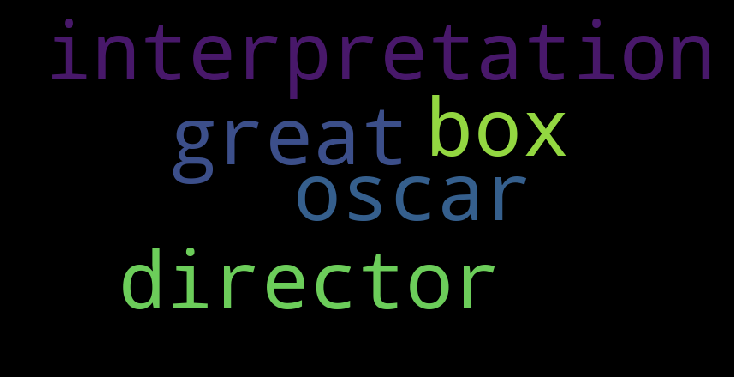

In [106]:
words = ' '.join(list(uni_df.index[:5]))
words_wc = WordCloud(width=800,height=400,background_color='black',max_words=6, mode="RGBA").generate(words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(words_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Top 5 trends using Bigram

In [107]:
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(clint_eastwood['ptweets'])
frequencies = sum(sparse_matrix).toarray()[0]
bi_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

bi_df.sort_values("frequency", inplace=True, ascending=False)

bi_df.head(5)

,frequency
box office,151
director guild,128
navy seal,113
guild selma,96
ignores history,62


In [108]:
print ("Clint Eastwood\r")
print ("*************\r")
for i in (range(6)):
    print (str(bi_df.index[i]) + " (" + str(bi_df.frequency[i]) + "tweets)\r")

Clint Eastwood
*************
box office (151tweets)
director guild (128tweets)
navy seal (113tweets)
guild selma (96tweets)
ignores history (62tweets)
sienna miller (51tweets)


## Bradley Cooper

### Top 5 trends using Unigram

In [109]:
word_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(bradley_cooper['ptweets'])
frequencies = sum(sparse_matrix).toarray()[0]
uni_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

uni_df.sort_values("frequency", inplace=True, ascending=False)

uni_df.head(5)

,frequency
great,735
oscar,650
actor,284
amazing,250
performance,240


In [110]:
print ("Bradley Cooper\r")
print ("*************\r")
for i in (range(6)):
    print (str(uni_df.index[i]) + " (" + str(uni_df.frequency[i]) + "tweets)\r")

Bradley Cooper
*************
great (735tweets)
oscar (650tweets)
actor (284tweets)
amazing (250tweets)
performance (240tweets)
navy (225tweets)


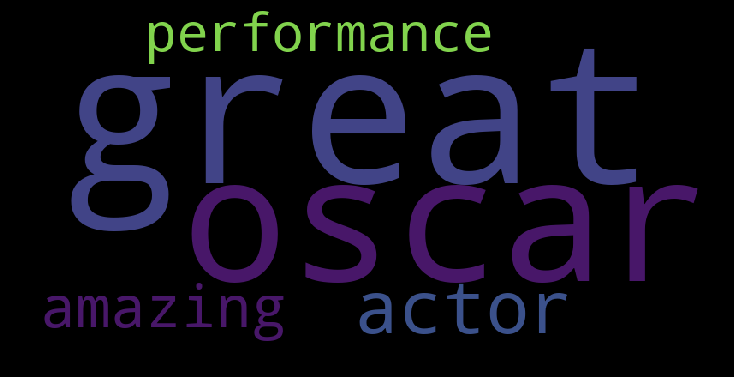

In [111]:
words = ' '.join(list(uni_df.index[:5]))
words_wc = WordCloud(width=800,height=400,background_color='black',max_words=6, mode="RGBA").generate(words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(words_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Top 5 trends using Bigram

In [112]:
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(bradley_cooper['ptweets'])
frequencies = sum(sparse_matrix).toarray()[0]
bi_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

bi_df.sort_values("frequency", inplace=True, ascending=False)

bi_df.head(5)

,frequency
navy seal,192
great actor,163
sensational portrayal,147
portrayal navy,141
sienna miller,122


In [113]:
print ("Bradley Cooper\r")
print ("*************\r")
for i in (range(6)):
    print (str(bi_df.index[i]) + " (" + str(bi_df.frequency[i]) + "tweets)\r")

Bradley Cooper
*************
navy seal (192tweets)
great actor (163tweets)
sensational portrayal (147tweets)
portrayal navy (141tweets)
sienna miller (122tweets)
oscar noms (118tweets)


## Chris Kyle

### Top 5 trends using Unigram

In [114]:

word_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(chris_kyle['ptweets'])
frequencies = sum(sparse_matrix).toarray()[0]
uni_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

uni_df.sort_values("frequency", inplace=True, ascending=False)

uni_df.head(5)

,frequency
memorial,862
edition,845
author,803
honor,786
hero,743


In [115]:
print ("Chris Kyle\r")
print ("*************\r")
for i in (range(6)):
    print (str(uni_df.index[i]) + " (" + str(uni_df.frequency[i]) + "tweets)\r")

Chris Kyle
*************
memorial (862tweets)
edition (845tweets)
author (803tweets)
honor (786tweets)
hero (743tweets)
great (567tweets)


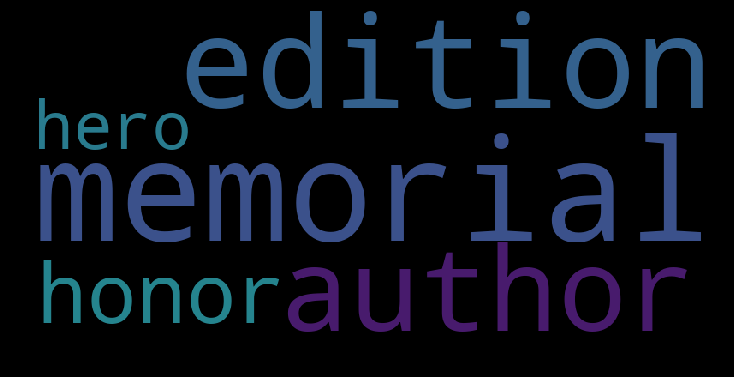

In [116]:
words = ' '.join(list(uni_df.index[:5]))
words_wc = WordCloud(width=800,height=400,background_color='black',max_words=6, mode="RGBA").generate(words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(words_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Top 5 trends using Bigram

In [117]:
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(chris_kyle['ptweets'])
frequencies = sum(sparse_matrix).toarray()[0]
bi_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

bi_df.sort_values("frequency", inplace=True, ascending=False)

bi_df.head(5)

,frequency
memorial edition,829
scott mcewen,427
navy seal,413
author scott,401
edition author,400


In [118]:
print ("Chris Kyle\r")
print ("*************\r")
for i in (range(6)):
    print (str(bi_df.index[i]) + " (" + str(bi_df.frequency[i]) + "tweets)\r")

Chris Kyle
*************
memorial edition (829tweets)
scott mcewen (427tweets)
navy seal (413tweets)
author scott (401tweets)
edition author (400tweets)
edition memorial (381tweets)


#### ======================================================================================